In [65]:
%matplotlib inline

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys

In [66]:
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.0.2


In [67]:
BASE_NAME = "/home/ubuntu/HeLa_20KInt-rt-4340-4580"
CONVERTED_DATABASE_NAME = '{}/HeLa_20KInt.sqlite'.format(BASE_NAME)

In [68]:
feature_list_filename = "{}/HeLa_20KInt-feature-list.csv".format(BASE_NAME)
feature_list_df = pd.read_csv(feature_list_filename)

In [69]:
allpeptides_df = pd.read_csv('/home/ubuntu/maxquant_results/txt/allPeptides.txt', sep='\t')

In [70]:
len(allpeptides_df)

328862

In [71]:
allpeptides_df.head()

,Raw file,Charge,m/z,Mass,Resolution,Number of data points,Number of frames,Number of isotopic peaks,Isotope correlation,Mass fractional part,...,Min frame index,Max frame index,Ion mobility index,Ion mobility index length,Ion mobility index length (FWHM),Intensity,Intensities,Number of pasef MS/MS,Pasef MS/MS IDs,MS/MS scan number
0,HeLa_20KInt_2KIT_Slot1-46_01_1179,1,326.37791,325.37063,24329.390330,3048,20,2,0.999609,0.370635,...,5137,5156,363,54,27,31429.0,NaN,0,NaN,NaN
1,HeLa_20KInt_2KIT_Slot1-46_01_1179,1,312.32607,311.31879,24234.331350,19515,75,2,0.992528,0.318792,...,5351,5425,501,51,21,81118.0,NaN,0,NaN,NaN
2,HeLa_20KInt_2KIT_Slot1-46_01_1179,1,316.28438,315.27711,24449.285122,706,7,2,0.999514,0.277105,...,5112,5118,549,75,27,36051.0,NaN,0,NaN,NaN
3,HeLa_20KInt_2KIT_Slot1-46_01_1179,1,307.09608,306.08880,24469.582565,7633,22,2,0.998656,0.088801,...,4935,4956,651,111,30,295110.0,NaN,0,NaN,NaN
4,HeLa_20KInt_2KIT_Slot1-46_01_1179,1,316.16858,315.16130,24514.638897,108,3,2,0.999752,0.161303,...,5032,5034,645,21,18,7543.2,NaN,0,NaN,NaN


In [72]:
allpeptides_df.rename(columns={'Number of isotopic peaks': 'isotope_count', 'm/z': 'mz', 'Intensity': 'intensity', 'Retention time': 'rt', 'Charge': 'charge'}, inplace=True)

In [73]:
feature_list_df.head()

,feature_id,charge_state,monoisotopic_mass,feature_centroid_scan,feature_centroid_rt,feature_centroid_mz,feature_start_rt,feature_end_rt,feature_scan_lower,feature_scan_upper,...,base_peak_scan_lower,base_peak_scan_upper,base_peak_centroid_rt,base_peak_std_dev_rt,base_peak_rt_lower,base_peak_rt_upper,base_peak_centroid_mz,base_peak_std_dev_mz,base_peak_mz_lower,base_peak_mz_upper
0,1,2,1789.903876,432.554732,4432.861258,896.398529,4427.824409,4443.177867,422,442,...,422,442,4433.020714,2.598279,4430.187565,4440.816682,895.958387,0.004415,895.917833,895.998069
1,2,2,1753.793257,414.272995,4459.104625,878.396096,4449.083986,4471.506226,405,425,...,405,425,4459.755071,4.440888,4449.083986,4471.506226,878.405911,0.006066,878.371983,878.442083
2,3,2,1658.901506,438.122446,4400.319978,830.627797,4390.028733,4412.471973,426,446,...,426,446,4400.557071,2.519410,4390.028733,4412.471973,830.458480,0.005567,830.406597,830.492932
3,4,2,1424.730227,486.765365,4533.062044,713.624696,4519.935285,4542.374700,472,492,...,472,492,4532.433233,3.352277,4529.382170,4542.374700,713.372265,0.002964,713.340924,713.404096
4,5,2,1424.729543,482.752245,4529.693034,713.687159,4519.935285,4540.014544,478,496,...,478,493,4529.118263,3.873986,4519.935285,4540.014544,713.372338,0.005519,713.340924,713.408308


In [74]:
feature_list_subset_df = feature_list_df[["feature_id","mono_peak_centroid_mz","mono_peak_centroid_rt","mono_peak_centroid_scan","monoisotopic_mass","feature_summed_intensity","charge_state"]].copy()

In [75]:
feature_list_subset_df.sort_values(by=['feature_summed_intensity'], ascending=False, inplace=True)

In [76]:
allpeptides_subset_df = allpeptides_df[["mz","intensity","charge","rt","Ion mobility index"]].copy()

In [77]:
allpeptides_subset_df.sort_values(by=['intensity'], ascending=False).head()

,mz,intensity,charge,rt,Ion mobility index
273238,895.95670,26707000.0,2,4432.552,363
195754,714.35058,25183000.0,1,3224.585,183
155746,655.86110,23453000.0,2,4728.970,474
206499,706.40506,21142000.0,2,3332.142,540
311960,1108.04640,19726000.0,2,4999.334,204


Enumerate the MQ features

In [78]:
allpeptides_subset_df = allpeptides_subset_df[allpeptides_subset_df.intensity.notnull()].copy()

allpeptides_subset_df.sort_values(by=['intensity'], ascending=False, inplace=True)
allpeptides_subset_df["mq_feature_id"] = np.arange(start=1, stop=len(allpeptides_subset_df)+1)

In [79]:
df = []

MZ_TOLERANCE_PPM = 5
MZ_TOLERANCE_PERCENT = MZ_TOLERANCE_PPM * 10**-4 
# RT_TOLERANCE_SECS = 6
# DRIFT_TOLERANCE = 10
# set wide to look at nearby features
RT_TOLERANCE_SECS = 30
DRIFT_TOLERANCE = 50

allpeptides_subset_df["mz_delta"] = allpeptides_subset_df.mz * MZ_TOLERANCE_PERCENT / 100
allpeptides_subset_df["mz_upper"] = allpeptides_subset_df.mz + allpeptides_subset_df.mz_delta
allpeptides_subset_df["mz_lower"] = allpeptides_subset_df.mz - allpeptides_subset_df.mz_delta

allpeptides_subset_df["rt_upper"] = allpeptides_subset_df.rt + RT_TOLERANCE_SECS
allpeptides_subset_df["rt_lower"] = allpeptides_subset_df.rt - RT_TOLERANCE_SECS

allpeptides_subset_df["drift_upper"] = allpeptides_subset_df["Ion mobility index"] + DRIFT_TOLERANCE
allpeptides_subset_df["drift_lower"] = allpeptides_subset_df["Ion mobility index"] - DRIFT_TOLERANCE

In [80]:
MQ_FEATURE_ID = 8

In [81]:
mq_feature_df = allpeptides_subset_df[allpeptides_subset_df.mq_feature_id == MQ_FEATURE_ID].iloc[0]

mz_lower = mq_feature_df.mz_lower
mz_upper = mq_feature_df.mz_upper
rt_lower = mq_feature_df.rt_lower
rt_upper = mq_feature_df.rt_upper
drift_lower = mq_feature_df.drift_lower
drift_upper = mq_feature_df.drift_upper
charge = mq_feature_df.charge

matches_df = feature_list_subset_df[
                            (
                                (feature_list_subset_df.mono_peak_centroid_mz >= mz_lower) &
                                (feature_list_subset_df.mono_peak_centroid_mz <= mz_upper)
                            ) &
                            (
                                (feature_list_subset_df.mono_peak_centroid_rt >= rt_lower) &
                                (feature_list_subset_df.mono_peak_centroid_rt <= rt_upper)
                            ) &
                            (
                                (feature_list_subset_df.mono_peak_centroid_scan >= drift_lower) &
                                (feature_list_subset_df.mono_peak_centroid_scan <= drift_upper)
                            ) &
                            (
                                charge == feature_list_subset_df.charge_state
                            )
]

In [82]:
mq_feature_rt = mq_feature_df.rt
mq_feature_rt

4457.345

In [83]:
matches_df

,feature_id,mono_peak_centroid_mz,mono_peak_centroid_rt,mono_peak_centroid_scan,monoisotopic_mass,feature_summed_intensity,charge_state
1,2,877.904042,4459.626480,415.517356,1753.793257,4246085,2
205,207,877.903245,4456.673599,410.343762,1753.789574,2871543,2
185,187,877.904116,4465.574726,415.568289,1753.791831,2183397,2
489,493,877.904515,4454.710701,446.336689,1753.794236,547256,2
722,726,877.898779,4473.753868,420.577273,1753.782217,544028,2
1788,1801,877.898305,4444.262161,415.846896,1753.782041,158823,2
4103,4145,877.900433,4470.157722,456.234485,1753.787009,123268,2
3533,3568,877.899226,4444.364976,451.926276,1755.608755,107874,2
4965,5019,877.897590,4478.783319,425.277014,1753.779344,63452,2


In [84]:
feature_ids = matches_df.feature_id.tolist()
feature_ids

[2, 207, 187, 493, 726, 1801, 4145, 3568, 5019]

In [85]:
feature_raw_points_df_list = []
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
for feature_id in feature_ids:
    df = pd.read_sql_query("select * from frames where (frame_id,point_id) in (select raw_frame_id,raw_point_id from raw_summed_join where (summed_frame_id,summed_point_id) in (select frame_id,point_id from summed_frames where (frame_id,peak_id) in (select frame_id,peak_id from peaks where (frame_id,cluster_id) in (select frame_id,cluster_id from clusters where feature_id=={}))))".format(feature_id), db_conn)
    df["hover"] = df["mz"].map('{:,.4f} m/z'.format) + ', ' + df["scan"].map('{} scan'.format) + ', feature {}'.format(feature_id)
    feature_raw_points_df_list.append((df))
db_conn.close()

In [86]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Rescale to values between 0 and 1
tableau20_mpl = tableau20.copy()
for i in range(len(tableau20_mpl)):  
    r, g, b = tableau20_mpl[i]  
    tableau20_mpl[i] = (r / 255., g / 255., b / 255.)

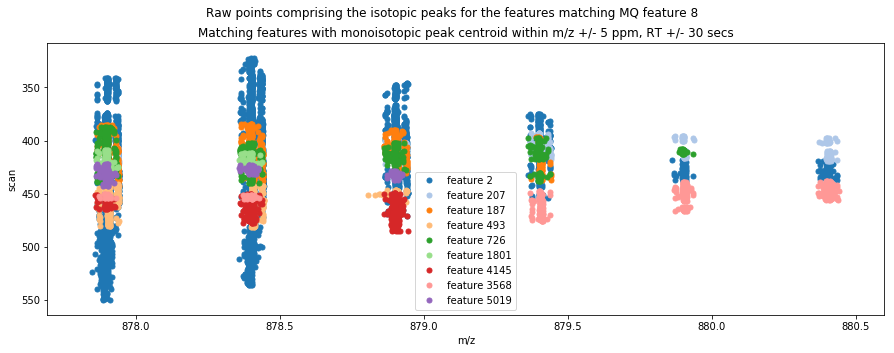

In [87]:
f, ax = plt.subplots()
for idx,feature_id in enumerate(feature_ids):
    feature_raw_points_df = feature_raw_points_df_list[idx]
    ax.plot(feature_raw_points_df.mz, feature_raw_points_df.scan, marker='o', color=tableau20_mpl[idx], linestyle='', ms=5, label="feature {}".format(feature_id))
plt.legend(loc='best')
plt.xlabel('m/z')
plt.ylabel('scan')
plt.gca().invert_yaxis()
f.set_figheight(5)
f.set_figwidth(15)
plt.suptitle('Raw points comprising the isotopic peaks for the features matching MQ feature {}'.format(MQ_FEATURE_ID))
plt.title('Matching features with monoisotopic peak centroid within m/z +/- {} ppm, RT +/- {} secs'.format(MZ_TOLERANCE_PPM, RT_TOLERANCE_SECS))
plt.margins(0.06)
plt.show()

In [88]:
# find the feature's apex frame
df = feature_raw_points_df_list[0]
apex_frame_id = df.iloc[df.intensity.idxmax()].frame_id
print("apex frame of feature {}: {}".format(feature_ids[0],apex_frame_id))

apex frame of feature 2: 41489


In [89]:
feature_apex_frame_df_list = []
for idx,feature_id in enumerate(feature_ids):
    df = feature_raw_points_df_list[idx]
    df = df[(df.frame_id == apex_frame_id)]
    feature_apex_frame_df_list.append((df))

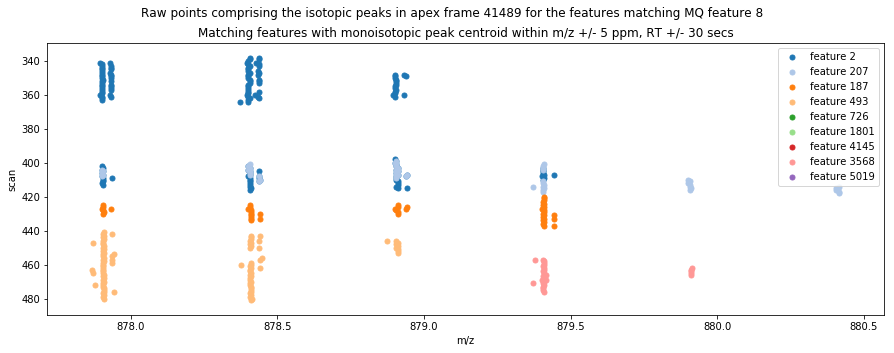

In [90]:
f, ax = plt.subplots()
for idx,feature_id in enumerate(feature_ids):
    df = feature_apex_frame_df_list[idx]
    ax.plot(df.mz, df.scan, marker='o', color=tableau20_mpl[idx], linestyle='', ms=5, label="feature {}".format(feature_id))
plt.legend(loc='best')
plt.xlabel('m/z')
plt.ylabel('scan')
plt.gca().invert_yaxis()
f.set_figheight(5)
f.set_figwidth(15)
plt.suptitle('Raw points comprising the isotopic peaks in apex frame {} for the features matching MQ feature {}'.format(apex_frame_id, MQ_FEATURE_ID))
plt.title('Matching features with monoisotopic peak centroid within m/z +/- {} ppm, RT +/- {} secs'.format(MZ_TOLERANCE_PPM, RT_TOLERANCE_SECS))
plt.margins(0.06)
plt.show()

In [91]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

print(__version__) # requires version >= 1.9.0

3.5.0


In [92]:
init_notebook_mode(connected=True)

In [93]:
tableau20_py = tableau20.copy()

In [107]:
import plotly.plotly as py
import plotly.graph_objs as go

traces = []
for idx,feature_id in enumerate(feature_ids):
    df = feature_apex_frame_df_list[idx]
    if len(df) > 0:
        trace = go.Scatter3d(
            x = df.mz,
            y = df.scan,
            z = df.intensity,
            mode = 'markers',
            marker = dict(
                size = 5,
                color = "rgb{}".format(tableau20_py[idx]),
                opacity = 0.8,
                line = dict(
                    color = 'rgb(128, 128, 128)',
                    width = 0.1
                )
            ),
            text = df.hover,
            hoverinfo = 'text',
            name = "feature {}".format(feature_id)
        )
        traces.append((trace))


data = traces
layout = go.Layout(
    autosize=False,
    width=900,
    height=600,
    title='Raw points comprising the isotopic peaks in apex frame {} for the features matching MQ feature {}'.format(apex_frame_id, MQ_FEATURE_ID),
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=40
    ),
    scene = dict(
        xaxis = dict(
            title='m/z', autorange='reversed'),
        yaxis = dict(
            title='scan'),
        zaxis = dict(
            title='intensity')
    )
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)